In [1]:
import argparse
import os
import sys
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.distributions import Poisson
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
from PIL import Image

sys.path.insert(0,'..') # So we can import point_density_functions from parent directory
from tools_optim import *

%load_ext autoreload
%autoreload 2

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is latent vector Z of shape (nz x 1 x 1), going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
              # state size. (ngf*16) x 4 x 4, where 4 = n+k-1= 1+4-1
              # to figure out the dimension of convtrans, just ask what dimension with the current setting gets you the current dimension
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
              # state size. (ngf*8) x 8 x 8, where 8 = (n-1)*s+k-2p = 3*2+4-2
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
              # state size. (ngf*4) x 16 x 16, where 16 = (n-1)*s+k-2p = 7*2+4-2
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
              # state size. (ngf*2) x 32 x 32, where 32 = (n-1)*s+k-2p = 15*2+4-2
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 64 x 64, where 64 = (n-1)*s+k-2p = 31*2+4-2
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 128 x 128, where 128 = (n-1)*s+k-2p = 63*2+4-2
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 256 x 256, where 256 = (n-1)*s+k-2p = 127*2+4-2
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
              # state size. (nc) x 512 x 512, where 512 = (n-1)*s+k-2p = 255*2+4-2
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

### Test 1: Find image in GAN latent space

In [4]:
## Load the generators
# Always true for microscope data
grayscale = True

# Load the generators UPDATE THIS FOR LOCATION OF MODELS
generator50 = torch.load("../../models/microscope/nz50_e200_G")
generator100 = torch.load("../../models/microscope/nz100_e400_G")
generator150 = torch.load("../../models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    device= 'cuda'
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()
else:
    device = 'cpu'

generator50.eval()
generator100.eval()
generator150.eval()

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

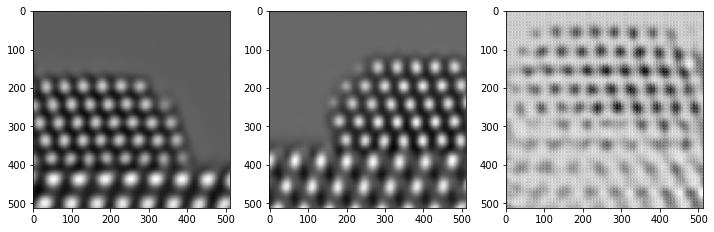

In [5]:
# Initialize z, the target latent vector 
z50 = torch.randn(1,50,1,1,device=device)
z100 = torch.randn(1,100,1,1,device=device)
z150 = torch.randn(1,150,1,1,device=device)

# Generate im, the target image
im50 = (generator50(z50).detach()*0.5)+0.5
im100 = (generator100(z100).detach()*0.5)+0.5
im150 = (generator150(z150).detach()*0.5)+0.5

# Plot the images
plt.figure(figsize=[12,5])
plt.subplot(1,3,1)
plot_img(im50,grayscale,vmin=0,vmax=1)
plt.subplot(1,3,2)
plot_img(im100,grayscale,vmin=0,vmax=1)
plt.subplot(1,3,3)
plot_img(im150,grayscale,vmin=0,vmax=1)

In [ ]:
# z100 = torch.randn(64,100,1,1,device=device)

# # Generate im, the target image in a variety of batch sizes
# im_1 = generator100(z100[0].unsqueeze(0)).detach().cpu()
# im_2 = generator100(z100[:2]).detach().cpu()
# im_4 = generator100(z100[:4]).detach().cpu()
# im_64 = generator100(z100).detach().cpu()

# # Plot the images of the image corresponding to the first vector in each batch
# plt.figure(figsize=[12,5])
# plt.subplot(1,4,1)
# plot_img(im_1,grayscale,vmin=0,vmax=1)
# plt.title("Batch of 1")
# plt.subplot(1,4,2)
# plot_img(im_2[0].unsqueeze(0),grayscale,vmin=0,vmax=1)
# plt.title("Batch of {}".format(im_2.shape[0]))
# plt.subplot(1,4,3)
# plot_img(im_4[0].unsqueeze(0),grayscale,vmin=0,vmax=1)
# plt.title("Batch of {}".format(im_4.shape[0]))
# plt.subplot(1,4,4)
# plot_img(im_64[0].unsqueeze(0),grayscale,vmin=0,vmax=1)
# plt.title("Batch of {}".format(im_64.shape[0]))

In [6]:
# Initialize x, the initial latent vector
x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
x_keep100 = Variable(torch.randn(1,100,1,1,device=device),requires_grad=False)
x_keep150 = Variable(torch.randn(1,150,1,1,device=device),requires_grad=False)

In [7]:
op = torch.optim.Adam
lr = 1e-2

generator_list = [generator50,generator100,generator150]
x_keep_list = [x_keep50,
               x_keep100,
               x_keep150]
im_list = [im50,im100,im150]

loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=20000)

Epoch 0	 Loss: 0.0097	 X Norm: 7.4151
Epoch 100	 Loss: 0.0039	 X Norm: 7.4294
Epoch 200	 Loss: 0.0038	 X Norm: 7.3417


KeyboardInterrupt: 

In [ ]:
plot_loss_curve(loss_dict,title='Learning curves for DCGAN on image in training set',start_idx=2000)

In [ ]:
# Compare loss across optimzers at a given epoch
for k in loss_dict.keys():
    print(k,": ",loss_dict[k][-1])

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(2,3,1)
plt.title("z = 50")
plt.ylabel("Original")
plot_img(im_list[0],grayscale)

plt.subplot(2,3,4)
k = sorted(im_dict.keys())[2]
plt.title(k)
plt.ylabel("Generated")
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(2,3,2)
plt.title("z = 100")
plot_img(im_list[1],grayscale)

plt.subplot(2,3,5)
k = sorted(im_dict.keys())[0]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(2,3,3)
plt.title("z = 200")
plot_img(im_list[2],grayscale)

plt.subplot(2,3,6)
k = sorted(im_dict.keys())[1]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

In [ ]:
# What's the norm of the difference between the vectors?
for z,x in zip([z50,z100,z150],[x_dict['z=50'][:,:,0,0].to('cpu'),
                                x_dict['z=100'][:,:,0,0].to('cpu'),
                                x_dict['z=150'][:,:,0,0].to('cpu')]):
    print("z={} norm: {:2.4f}\tOpt Norm: {:2.4f}\tDiff Norm {:2.4f}".format(z.size(1),torch.norm(z).item(),
                                                                            torch.norm(x).item(),torch.norm(z - x).item()))

## Test 2:  
Find closest image to random cropped sample

#### Load microscope image

In [ ]:
save_dir = '../../microscope_output/NEW_TEST_FOLDER/'

In [ ]:
class ParticleDatset(torch.utils.data.Dataset):
    def __init__(self, root_dir,im_size=512):
        super().__init__()
        self.root_dir = root_dir
        self.im_list = os.listdir(root_dir)
        self.n = len(self.im_list)
        self.im_size = im_size

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        im = Image.open(root_dir+self.im_list[index])
        im = transforms.RandomCrop(self.im_size)(im)
        out = transforms.ToTensor()(im)
#         out = transforms.Normalize(0.5,0.5)(out)
        return out

root_dir = 'data/microscope/10/10/'  # UPDATE THIS FOR LOCATION OF MICROSCOPE DATA
dataset = ParticleDatset(root_dir,512)
dataloader =  torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True)

In [9]:
# Always true for microscope data
grayscale = True

# Load the generators
generator50 = torch.load("../../models/microscope/nz50_e200_G")
generator100 = torch.load("../../models/microscope/nz100_e400_G")
generator150 = torch.load("../../models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    device='cuda'
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()

generator50.eval()
generator100.eval()
generator150.eval()

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
# Initialize x, the initial latent vector
# x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
# x_keep100 = Variable(torch.randn(1,100,1,1,device=device),requires_grad=False)
# x_keep150 = Variable(torch.randn(1,150,1,1,device=device),requires_grad=False)
x_keep50 = torch.randn(1,50,1,1,device=device)
x_keep100 = torch.randn(1,100,1,1,device=device)
x_keep150 = torch.randn(1,150,1,1,device=device)

# Generate im, the target image
im = next(iter(dataloader))
im = im.to('cuda')
plot_img(im,grayscale,vmin=0,vmax=1)

In [ ]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = (generator50(x_keep50)*0.5)+0.5
    plot_img(im_first,grayscale)

In [ ]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = (generator100(x_keep100)*0.5)+0.5
    plot_img(im_first,grayscale)

In [ ]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = (generator150(x_keep150)*0.5)+0.5
    plot_img(im_first,grayscale)

In [ ]:

### Loop thru lots of random starting points
op = torch.optim.Adam
lr = 1e-2

# Accumulators
big_loss_list = []
big_psnr_list = []
big_x_list = []
for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = torch.randn(1,50,1,1,device=device)
    x_keep100 = torch.randn(1,100,1,1,device=device)
    x_keep150 = torch.randn(1,150,1,1,device=device)    
    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50,
                   x_keep100,
                   x_keep150]
    im_list = [im,im,im]
    
    loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=1500)
    big_loss_list.append(loss_dict)
    big_psnr_list.append(psnr_dict)
    big_x_list.append(x_dict)

In [ ]:
# Dot plots for all three latent dimensions
loss50 = []
loss100 = []
loss150 = []
for i,loss in enumerate(big_loss_list):
    loss50.append(np.min(loss['z=50']))
    loss100.append(np.min(loss['z=100']))
    loss150.append(np.min(loss['z=150']))
    
print("Min loss 50: {:2.4f}".format(np.min(loss50)))
print("Min loss 100: {:2.4f}".format(np.min(loss100)))
print("Min loss 150: {:2.4f}".format(np.min(loss150)))

plt.scatter(50*np.ones(len(loss50)),loss50,marker='x')
plt.scatter(100*np.ones(len(loss100)),loss100,marker='x')
plt.scatter(150*np.ones(len(loss150)),loss150,marker='x')
plt.xlabel("Latent dimension")
plt.xticks([50,100,150],[50,100,150])
plt.ylabel("Reconstruction loss per pixel")
plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")
plt.savefig(save_dir+"dot_plot.png")

In [ ]:
# Find the best of the samples, optimizer further
# z = 50
idx = np.argmin(loss50)
x_keep = big_x_list[idx]['z=50']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list50, psnr_list50, im_g50, x_out50 = grad_loop(im,x_keep,generator50,optimizer,
                                   scheduler=scheduler, n_epochs=10000,epsilon=1e-5)

# z = 100
idx = np.argmin(loss100)
x_keep = big_x_list[idx]['z=100']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list100, psnr_list100, im_g100, x_out100 = grad_loop(im,x_keep,generator100,optimizer,
                                   scheduler=scheduler, n_epochs=10000,epsilon=1e-5)

# z = 150
idx = np.argmin(loss150)
x_keep = big_x_list[idx]['z=150']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list150, psnr_list150, im_g150, x_out150 = grad_loop(im,x_keep,generator150,optimizer,
                                   scheduler=scheduler, n_epochs=10000,epsilon=1e-5)

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list50,label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list100,label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list150,label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("PSNR")
plt.savefig(save_dir+"psnr_curve.png")

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list50],label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list100],label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list150],label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("Reconstruction Loss")
plt.savefig(save_dir+"learning_curve.png")

In [ ]:
# PSNR Max
print("PSNR")
print("50: ",np.max(psnr_list50))
print("100: ",np.max(psnr_list100))
print("150: ",np.max(psnr_list150))

# Reconstruction Loss
print("\nReconstruction Loss")
print("50: ",loss_list50[-1]*512*512)
print("100: ",loss_list100[-1]*512*512)
print("150: ",loss_list150[-1]*512*512)

In [ ]:
# Save latent vectors to compare with vacuum space
# x_nano50 = torch.load('x_out50_nanoparticles.pt')
# x_nano100 = torch.load('x_out100_nanoparticles.pt')
# x_nano150 = torch.load('x_out150_nanoparticles.pt')
torch.save(x_out50,save_dir+"x_out50.pt")
torch.save(x_out100,save_dir+"x_out100.pt")
torch.save(x_out150,save_dir+"x_out150.pt")
torch.save(im,save_dir+"im.pt")

In [ ]:
vmin=0
vmax=1

# Reconstruction
plt.figure(figsize=[12,6])
plt.subplot(1,4,1)
plt.title("Original")
plot_img(im,grayscale,vmin,vmax)

plt.subplot(1,4,2)
plt.title("z=150")
# after optimizing
with torch.no_grad():
    plot_img(im_g150,grayscale,vmin,vmax)

plt.subplot(1,4,3)
plt.title("z=100")
# after optimizing
with torch.no_grad():
    plot_img(im_g100,grayscale,vmin,vmax)

plt.subplot(1,4,4)
plt.title("z=50")
# after optimizing
with torch.no_grad():
    plot_img(im_g50,grayscale,vmin,vmax)

# plt.savefig(save_dir+"reconstruction.png")

In [ ]:
# Latent vector distribution
# Means and SDs
mean50 = x_out50.mean()
sd50 = x_out50.std()
mean100 = x_out100.mean()
sd100 = x_out100.std()
mean150 = x_out150.mean()
sd150 = x_out150.std()

## Distribution of vector values
plt.figure(figsize=[16,6])
plt.subplot(1,3,1)
plt.hist(x_out50[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=50\nMean: {:2.4f}   SD: {:2.4f}".format(mean50,sd50))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,2)
plt.hist(x_out100[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=100\nMean: {:2.4f}   SD: {:2.4f}".format(mean100,sd100))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,3)
plt.hist(x_out150[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=150\nMean: {:2.4f}   SD: {:2.4f}".format(mean150,sd150))
plt.xlabel("z element value")
plt.ylabel("Frequency")

plt.savefig(save_dir+"latent_hist.png")

## Test 3: Add Noise

In [ ]:
save_dir = '../../microscope_output/NEW_TEST_FOLDER/'

In [ ]:
class Args(object):
    def __init__(self):
        self.data_path = '../../data/microscope/10/'
        self.dataset = 'ptceo2'
        self.batch_size = 1
        self.checkpoint_path = '../../nanoparticle_denoising_master/nanoparticle_denoising_master/pretrained/checkpoint_best.pt'
        self.output_path = '../../microscope_output/supervised/'
        self.no_cuda = False
args=Args()

In [ ]:
device = torch.device("cuda") if (
    torch.cuda.is_available() and not args.no_cuda) else torch.device("cpu")
# Load arguments from previous checkpoint
state_dict = torch.load(
    args.checkpoint_path,
    map_location=lambda s,
    l: default_restore_location(
        s,
        "cpu"))
args = argparse.Namespace(
    **{**vars(args), **vars(state_dict["args"]), "no_log": True})
utils.init_logging(args)

# Build data loader and load model

super_model = models.build_model(args).to(device)
super_model.load_state_dict(state_dict["model"][0])
super_model.eval()

In [ ]:
grayscale = True
# Generate im, the target image
clean = next(iter(dataloader))
clean = clean.to('cuda')
plot_img(clean,grayscale,vmin=0,vmax=1)

In [ ]:
# Noise Functions
def add_gauss_noise(data, noise_std = .1):
    noise = torch.randn_like(data);
    noise = noise * noise_std;
    return data + noise

def add_poiss_noise(clean,noise_scale=1):
    noise = torch.clamp((Poisson(clean * noise_scale).sample() / noise_scale),0,1)
    return noise

In [ ]:
# Poisson noise
poiss_noise_scale=[25,10,1]

p_noise_0 = add_poiss_noise(clean,poiss_noise_scale[0])
p_noise_1 = add_poiss_noise(clean,poiss_noise_scale[1])
p_noise_2 = add_poiss_noise(clean,poiss_noise_scale[2])

gauss_noise_scale = [.1,.5,1]
g_noise_0 = add_gauss_noise(clean,gauss_noise_scale[0])
g_noise_1 = add_gauss_noise(clean,gauss_noise_scale[1])
g_noise_2 = add_gauss_noise(clean,gauss_noise_scale[2])

plt.figure(figsize = [12,6])
plt.subplot(2,4,1)
plot_img(clean,grayscale,vmin=0,vmax=1)
plt.title("Clean")
plt.subplot(2,4,2)
plot_img(p_noise_0,grayscale,vmin=0,vmax=1)
plt.title("Poisson, noise_scale = {}".format(poiss_noise_scale[0]))
plt.subplot(2,4,3)
plot_img(p_noise_1,grayscale,vmin=0,vmax=1)
plt.title("Poisson, noise_scale = {}".format(poiss_noise_scale[1]))
plt.subplot(2,4,4)
plot_img(p_noise_2,grayscale,vmin=0,vmax=1)
plt.title("Poisson, noise_scale = {}".format(poiss_noise_scale[2]))

plt.subplot(2,4,5)
plot_img(clean,grayscale,vmin=0,vmax=1)
plt.title("Clean")
plt.subplot(2,4,6)
plot_img(g_noise_0,grayscale,vmin=0,vmax=1)
plt.title("Gaussian, noise_scale = {}".format(gauss_noise_scale[0]))
plt.subplot(2,4,7)
plot_img(g_noise_1,grayscale,vmin=0,vmax=1)
plt.title("Gaussian, noise_scale = {}".format(gauss_noise_scale[1]))
plt.subplot(2,4,8)
plot_img(g_noise_2,grayscale,vmin=0,vmax=1)
plt.title("Gaussian, noise_scale = {}".format(gauss_noise_scale[2]))

In [ ]:
im_list = [clean,p_noise_0,p_noise_1,p_noise_2,g_noise_0,g_noise_1,g_noise_2]

filename = "denoise_images.dat"
# os.mkdir(save_dir)
with open(save_dir+filename, "wb") as f:
    pickle.dump(im_list, f)

### Load images, run test

In [ ]:
filename = "denoise_images.dat"
with open('../../microscope_output/comparison_test/'+filename, "rb") as f:
    im_full_list = pickle.load(f)

In [ ]:
# Always true for microscope data
grayscale = True

# Load the generators
generator50 = torch.load("../../models/microscope/nz50_e200_G")
generator100 = torch.load("../../models/microscope/nz100_e400_G")
generator150 = torch.load("../../models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    device='cuda'
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()

generator50.eval()
generator100.eval()
generator150.eval()

In [ ]:
x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
op_list = [torch.optim.SGD,torch.optim.Adam]
lr_list = [1e-2,1e-3,1e-4]
loss_dict,psnr_dict,im_dict = convergence_loop(op_list,lr_list,generator50,x_keep50,im_list[0])

In [ ]:
def plot_psnr_curve(loss_dict,title,keys=None):
    # Given a loss_dict where the optimizer name and LR are the key, plots the learning curves
    if keys == None:
        keys = loss_dict.keys()
    plt.figure(figsize=[15,9])
    for k in keys:
        plt.plot(np.arange(0,100*len(loss_dict[k]),100),loss_dict[k],label=str(k))
    plt.legend(loc='below',fontsize=12)
    plt.ylabel("PSNR",fontsize=12)
    plt.xlabel("Epoch",fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
plot_psnr_curve(psnr_dict,"PSNR curves for different optimizers on electron microscope images.")

In [ ]:
psnr_dict = {}
for key in loss_dict.keys():
    loss_list= loss_dict[key]
    psnr_list = [-10 * np.log10(ll) for ll in loss_list]
    psnr_dict[key] = psnr_list

In [ ]:
psnr_dict

In [ ]:
denoise=True
# im_idx = 2
for im_idx in [2]:
    save_dir = '../../microscope_output/comparison_test_otherG/im_'+str(im_idx)+'/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    ### Loop thru lots of random starting points
    op = torch.optim.Adam
    lr = 1e-2

    # Accumulators
    big_loss_list = []
    big_psnr_list = []
    big_psnr_clean_list = []
    big_x_list = []

    for i in range(10):
        # Initialize x, the initial latent vector
        x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
        x_keep100 = Variable(torch.randn(1,100,1,1,device=device),requires_grad=False)
        x_keep150 = Variable(torch.randn(1,150,1,1,device=device),requires_grad=False)

        generator_list = [generator50,generator100,generator150]
        x_keep_list = [x_keep50,
                       x_keep100,
                       x_keep150]
        im_list = [im_full_list[im_idx],im_full_list[im_idx],im_full_list[im_idx]]

        loss_dict, psnr_dict, psnr_clean_dict, im_dict, x_dict = latent_dim_loop(generator_list,
                                                                   x_keep_list,im_list,op,lr,
                                                                   clean=im_full_list[0],denoise=denoise,n_epochs=1500)
    #     loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=1500)
        big_loss_list.append(loss_dict)
        big_psnr_list.append(psnr_dict)
        if denoise:
            big_psnr_clean_list.append(psnr_clean_dict)
        big_x_list.append(x_dict)


    # Cell 2
    # Dot plots for all three latent dimensions
    loss50 = []
    loss100 = []
    loss150 = []
    for i,loss in enumerate(big_loss_list):
        loss50.append(np.min(loss['z=50']))
        loss100.append(np.min(loss['z=100']))
        loss150.append(np.min(loss['z=150']))

    print("Min loss 50: {:2.4f}".format(np.min(loss50)))
    print("Min loss 100: {:2.4f}".format(np.min(loss100)))
    print("Min loss 150: {:2.4f}".format(np.min(loss150)))

    plt.scatter(50*np.ones(len(loss50)),loss50,marker='x')
    plt.scatter(100*np.ones(len(loss100)),loss100,marker='x')
    plt.scatter(150*np.ones(len(loss150)),loss150,marker='x')
    plt.xlabel("Latent dimension")
    plt.xticks([50,100,150],[50,100,150])
    plt.ylabel("Reconstruction loss per pixel")
    plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")
    plt.savefig(save_dir+"dot_plot.png")

    # Cell 3
    # Find the best of the samples, optimizer further
    # z = 50
    idx = np.argmin(loss50)
    x_keep = big_x_list[idx]['z=50']
    # x = x_keep.clone().requires_grad_()
    optimizer = torch.optim.Adam([x_keep],lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
    loss_list50, psnr_list50, psnr_clean_list50, im_g50, x_out50 = grad_loop(im_full_list[im_idx],x_keep,generator50,optimizer,
                                       scheduler=scheduler,clean=im_full_list[0],denoise=True, n_epochs=10000,epsilon=1e-5)

    # z = 100
    idx = np.argmin(loss100)
    x_keep = big_x_list[idx]['z=100']
    # x = x_keep.clone().requires_grad_()
    optimizer = torch.optim.Adam([x_keep],lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
    loss_list100, psnr_list100, psnr_clean_list100, im_g100, x_out100 = grad_loop(im_full_list[im_idx],x_keep,generator100,optimizer,
                                       scheduler=scheduler, clean=im_full_list[0],denoise=True,n_epochs=10000,epsilon=1e-5)

    # z = 150
    idx = np.argmin(loss150)
    x_keep = big_x_list[idx]['z=150']
    # x = x_keep.clone().requires_grad_()
    optimizer = torch.optim.Adam([x_keep],lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
    loss_list150, psnr_list150, psnr_clean_list150, im_g150, x_out150 = grad_loop(im_full_list[im_idx],x_keep,generator150,optimizer,
                                       scheduler=scheduler,clean=im_full_list[0],denoise=True, n_epochs=10000,epsilon=1e-5)
    # Cell 4
    plt.figure(figsize=[8,8])
    plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list50,label="50")
    plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list100,label="100")
    plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list150,label="150")
    plt.legend()
    plt.xlabel("Epoch (x100)")
    plt.ylabel("PSNR (Noisy Image)")
    plt.savefig(save_dir+"psnr_curve.png")

    # Cell 5
    plt.figure(figsize=[8,8])
    plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list50,label="50")
    plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list100,label="100")
    plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list150,label="150")
    plt.legend()
    plt.xlabel("Epoch (x100)")
    plt.ylabel("PSNR")
    plt.savefig(save_dir+"psnr_clean_curve.png")

    # Cell 6

    plt.figure(figsize=[8,8])
    plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list50],label="50")
    plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list100],label="100")
    plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list150],label="150")
    plt.legend()
    plt.xlabel("Epoch (x100)")
    plt.ylabel("Reconstruction Loss")
    plt.savefig(save_dir+"learning_curve.png")

    # Cell 7
    # PSNR Max
    print("PSNR")
    print("50: ",np.max(psnr_list50))
    print("100: ",np.max(psnr_list100))
    print("150: ",np.max(psnr_list150))

    # PSNR Clean
    psnr50 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g50.detach().to('cpu').numpy())
    psnr100 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g100.detach().to('cpu').numpy())
    psnr150 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g150.detach().to('cpu').numpy())
    print("\nClean PSNR")
    print("50: ",psnr50)
    print("100: ",psnr100)
    print("150: ",psnr150)

    # Reconstruction Loss
    print("\nReconstruction Loss")
    print("50: ",loss_list50[-1]*512*512)
    print("100: ",loss_list100[-1]*512*512)
    print("150: ",loss_list150[-1]*512*512)

    # Cell 8
    # Save latent vectors to compare with vacuum space
    # x_nano50 = torch.load('x_out50_nanoparticles.pt')
    # x_nano100 = torch.load('x_out100_nanoparticles.pt')
    # x_nano150 = torch.load('x_out150_nanoparticles.pt')
    torch.save(x_out50,save_dir+"x_out50.pt")
    torch.save(x_out100,save_dir+"x_out100.pt")
    torch.save(x_out150,save_dir+"x_out150.pt")
    torch.save(im_full_list[0],save_dir+"im.pt")
    torch.save(im_full_list[im_idx],save_dir+"im_noise.pt")
    torch.save(im_g50,save_dir+"im_g50.pt")
    torch.save(im_g100,save_dir+"im_g100.pt")
    torch.save(im_g150,save_dir+"im_g150.pt")

    # Cell 9
    vmin=0
    vmax=1

    # Reconstruction
    plt.figure(figsize=[15,6])
    plt.subplot(1,5,1)
    plt.title("Original")
    plot_img(im_full_list[0],grayscale,vmin,vmax)

    plt.subplot(1,5,2)
    plt.title("Poisson Noise\nScale=10")
    plot_img(im_full_list[im_idx],grayscale,vmin,vmax)

    plt.subplot(1,5,3)
    plt.title("z=50\nPSNR: {:2.2f}".format(psnr50))
    # after optimizing
    with torch.no_grad():
        plot_img(im_g50,grayscale,vmin,vmax)

    plt.subplot(1,5,4)
    plt.title("z=100\nPSNR: {:2.2f}".format(psnr100))
    # after optimizing
    with torch.no_grad():
        plot_img(im_g100,grayscale,vmin,vmax)

    plt.subplot(1,5,5)
    plt.title("z=150\nPSNR: {:2.2f}".format(psnr150))
    # after optimizing
    with torch.no_grad():
        plot_img(im_g150,grayscale,vmin,vmax)

    plt.savefig(save_dir+"reconstruction.png")

    # PSNR Curves
    plot_psnr_multi(big_psnr_clean_list,psnr_clean_list50,50,"PSNR curve, z=50")
    plt.savefig(save_dir+"psnr_curve50.png")
    plot_psnr_multi(big_psnr_clean_list,psnr_clean_list100,100,"PSNR curve, z=100")
    plt.savefig(save_dir+"psnr_curve100.png")
    plot_psnr_multi(big_psnr_clean_list,psnr_clean_list150,150,"PSNR curve, z=150")
    plt.savefig(save_dir+"psnr_curve150.png")
    # Cell 10
    # Latent vector distribution
    # Means and SDs
    mean50 = x_out50.mean()
    sd50 = x_out50.std()
    mean100 = x_out100.mean()
    sd100 = x_out100.std()
    mean150 = x_out150.mean()
    sd150 = x_out150.std()

    ## Distribution of vector values
    plt.figure(figsize=[16,6])
    plt.subplot(1,3,1)
    plt.hist(x_out50[0,:,0,0].detach().to('cpu'),bins=20)
    plt.title("z=50\nMean: {:2.4f}   SD: {:2.4f}".format(mean50,sd50))
    plt.xlabel("z element value")
    plt.ylabel("Frequency")
    plt.subplot(1,3,2)
    plt.hist(x_out100[0,:,0,0].detach().to('cpu'),bins=20)
    plt.title("z=100\nMean: {:2.4f}   SD: {:2.4f}".format(mean100,sd100))
    plt.xlabel("z element value")
    plt.ylabel("Frequency")
    plt.subplot(1,3,3)
    plt.hist(x_out150[0,:,0,0].detach().to('cpu'),bins=20)
    plt.title("z=150\nMean: {:2.4f}   SD: {:2.4f}".format(mean150,sd150))
    plt.xlabel("z element value")
    plt.ylabel("Frequency")

    plt.savefig(save_dir+"latent_hist.png")
    torch.save(big_psnr_clean_list, save_dir+"big_psnr_clean_list_"+str(im_idx)+".pt")
    torch.save(psnr_clean_list50,save_dir+"psnr_clean_list50_"+str(im_idx)+".pt")
    torch.save(psnr_clean_list100,save_dir+"psnr_clean_list100_"+str(im_idx)+".pt")
    torch.save(psnr_clean_list150,save_dir+"psnr_clean_list150_"+str(im_idx)+".pt")

In [ ]:
# Dot plots for all three latent dimensions
p50 = []
p100 = []
p150 = []
for i,loss in enumerate(big_psnr_clean_list):
    p50.append(loss['z=50'])
    p100.append(loss['z=100'])
    p150.append(loss['z=150'])

idx50 = np.argmax([p[-1] for p in p50])
idx100 = np.argmax([p[-1] for p in p100])
idx150 = np.argmax([p[-1] for p in p150])

# combine the two halves
psnr50 = p50[idx50].append(psnr_clean_list50)
psnr100 = p100[idx100].append(psnr_clean_list100)
psnr150 = p150[idx150].append(psnr_clean_list150)

plt.figure(figsize=[15,9])
for k,label in zip([psnr50,psnr100,psnr150],['z=50','z=100','z=150']):
    plt.plot(np.arange(0,100*len(k),100),k,label=label)
# psnr_later = psnr_later_dict[z]
# plt.plot(np.arange(100*len(psnr_clean[k]),100*len(psnr_clean[k])+100*len(psnr_later),100),psnr_later)
title = 'PSNR Curve for latent dimension z = '+str(z)
plt.ylabel("PSNR",fontsize=12)
plt.xlabel("Epoch",fontsize=12)
plt.title(title,fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [ ]:
[p[-1] for p in p50]

In [ ]:
denoise=True
im_idx = 2
save_dir = '../../microscope_output/comparison test/im_'+str(im_idx)+'/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
### Loop thru lots of random starting points
op = torch.optim.Adam
lr = 1e-2

# Accumulators
big_loss_list = []
big_psnr_list = []
big_psnr_clean_list = []
big_x_list = []

for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
    x_keep100 = Variable(torch.randn(1,100,1,1,device=device),requires_grad=False)
    x_keep150 = Variable(torch.randn(1,150,1,1,device=device),requires_grad=False)
#     x_keep50 = torch.randn(1,50,1,1,device=device)
#     x_keep100 = torch.randn(1,100,1,1,device=device)
#     x_keep150 = torch.randn(1,150,1,1,device=device)
    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50,
                   x_keep100,
                   x_keep150]
    im_list = [im_full_list[im_idx],im_full_list[im_idx],im_full_list[im_idx]]

    loss_dict, psnr_dict, psnr_clean_dict, im_dict, x_dict = latent_dim_loop(generator_list,
                                                               x_keep_list,im_list,op,lr,
                                                               clean=im_full_list[0],denoise=denoise,n_epochs=1500)
#     loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=1500)
    big_loss_list.append(loss_dict)
    big_psnr_list.append(psnr_dict)
    if denoise:
        big_psnr_clean_list.append(psnr_clean_dict)
    big_x_list.append(x_dict)

In [ ]:
# Dot plots for all three latent dimensions
loss50 = []
loss100 = []
loss150 = []
for i,loss in enumerate(big_loss_list):
    loss50.append(np.min(loss['z=50']))
    loss100.append(np.min(loss['z=100']))
    loss150.append(np.min(loss['z=150']))
    
print("Min loss 50: {:2.4f}".format(np.min(loss50)))
print("Min loss 100: {:2.4f}".format(np.min(loss100)))
print("Min loss 150: {:2.4f}".format(np.min(loss150)))

plt.scatter(50*np.ones(len(loss50)),loss50,marker='x')
plt.scatter(100*np.ones(len(loss100)),loss100,marker='x')
plt.scatter(150*np.ones(len(loss150)),loss150,marker='x')
plt.xlabel("Latent dimension")
plt.xticks([50,100,150],[50,100,150])
plt.ylabel("Reconstruction loss per pixel")
plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")
plt.savefig(save_dir+"dot_plot.png")

In [ ]:
# Find the best of the samples, optimizer further
# z = 50
idx = np.argmin(loss50)
x_keep = big_x_list[idx]['z=50']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list50, psnr_list50, psnr_clean_list50, im_g50, x_out50 = grad_loop(im_full_list[im_idx],x_keep,generator50,optimizer,
                                   scheduler=scheduler,clean=im_full_list[0],denoise=True, n_epochs=10000,epsilon=1e-5)

# z = 100
idx = np.argmin(loss100)
x_keep = big_x_list[idx]['z=100']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list100, psnr_list100, psnr_clean_list100, im_g100, x_out100 = grad_loop(im_full_list[im_idx],x_keep,generator100,optimizer,
                                   scheduler=scheduler, clean=im_full_list[0],denoise=True,n_epochs=10000,epsilon=1e-5)

# z = 150
idx = np.argmin(loss150)
x_keep = big_x_list[idx]['z=150']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list150, psnr_list150, psnr_clean_list150, im_g150, x_out150 = grad_loop(im_full_list[im_idx],x_keep,generator150,optimizer,
                                   scheduler=scheduler,clean=im_full_list[0],denoise=True, n_epochs=10000,epsilon=1e-5)

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list50,label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list100,label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list150,label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("PSNR (Noisy Image)")
plt.savefig(save_dir+"psnr_curve.png")

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list50,label="50")
plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list100,label="100")
plt.plot(np.arange(0,len(psnr_clean_list50)*100,100),psnr_clean_list150,label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("PSNR")
plt.savefig(save_dir+"psnr_clean_curve.png")

In [ ]:
# psnr_clean_dict['z=100']
len(big_psnr_clean_list)

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list50],label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list100],label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list150],label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("Reconstruction Loss")
plt.savefig(save_dir+"learning_curve.png")

In [ ]:
# PSNR Max
print("PSNR")
print("50: ",np.max(psnr_list50))
print("100: ",np.max(psnr_list100))
print("150: ",np.max(psnr_list150))

# PSNR Clean
psnr50 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g50.detach().to('cpu').numpy())
psnr100 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g100.detach().to('cpu').numpy())
psnr150 = peak_signal_noise_ratio(im_full_list[0].to('cpu').numpy(),im_g150.detach().to('cpu').numpy())
print("\nClean PSNR")
print("50: ",psnr50)
print("100: ",psnr100)
print("150: ",psnr150)

# Reconstruction Loss
print("\nReconstruction Loss")
print("50: ",loss_list50[-1]*512*512)
print("100: ",loss_list100[-1]*512*512)
print("150: ",loss_list150[-1]*512*512)

In [ ]:
# Save latent vectors to compare with vacuum space
# x_nano50 = torch.load('x_out50_nanoparticles.pt')
# x_nano100 = torch.load('x_out100_nanoparticles.pt')
# x_nano150 = torch.load('x_out150_nanoparticles.pt')
torch.save(x_out50,save_dir+"x_out50.pt")
torch.save(x_out100,save_dir+"x_out100.pt")
torch.save(x_out150,save_dir+"x_out150.pt")
torch.save(im_full_list[0],save_dir+"im.pt")
torch.save(im_full_list[im_idx],save_dir+"im_noise.pt")
torch.save(im_g50,save_dir+"im_g50.pt")
torch.save(im_g100,save_dir+"im_g100.pt")
torch.save(im_g150,save_dir+"im_g150.pt")

In [ ]:
vmin=0
vmax=1

# Reconstruction
plt.figure(figsize=[15,6])
plt.subplot(1,5,1)
plt.title("Original")
plot_img(im_full_list[0],grayscale,vmin,vmax)

plt.subplot(1,5,2)
plt.title("Poisson Noise\nScale=10")
plot_img(im_full_list[im_idx],grayscale,vmin,vmax)

plt.subplot(1,5,3)
plt.title("z=50\nPSNR: {:2.2f}".format(psnr50))
# after optimizing
with torch.no_grad():
    plot_img(im_g50,grayscale,vmin,vmax)
    
plt.subplot(1,5,4)
plt.title("z=100\nPSNR: {:2.2f}".format(psnr100))
# after optimizing
with torch.no_grad():
    plot_img(im_g100,grayscale,vmin,vmax)

plt.subplot(1,5,5)
plt.title("z=150\nPSNR: {:2.2f}".format(psnr150))
# after optimizing
with torch.no_grad():
    plot_img(im_g150,grayscale,vmin,vmax)

plt.savefig(save_dir+"reconstruction.png")

In [ ]:
# Latent vector distribution
# Means and SDs
mean50 = x_out50.mean()
sd50 = x_out50.std()
mean100 = x_out100.mean()
sd100 = x_out100.std()
mean150 = x_out150.mean()
sd150 = x_out150.std()

## Distribution of vector values
plt.figure(figsize=[16,6])
plt.subplot(1,3,1)
plt.hist(x_out50[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=50\nMean: {:2.4f}   SD: {:2.4f}".format(mean50,sd50))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,2)
plt.hist(x_out100[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=100\nMean: {:2.4f}   SD: {:2.4f}".format(mean100,sd100))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,3)
plt.hist(x_out150[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=150\nMean: {:2.4f}   SD: {:2.4f}".format(mean150,sd150))
plt.xlabel("z element value")
plt.ylabel("Frequency")

plt.savefig(save_dir+"latent_hist.png")

## Test 4: REAL IMAGE!

In [ ]:
class RealParticleDatset(torch.utils.data.Dataset):
    def __init__(self, tif_file,im_size=512):
        super().__init__()
        self.tif_file = tif_file
        self.im_size = im_size
        self.images = io.imread(self.tif_file)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        im = torch.Tensor(self.images[0])
        starting_x = torch.randint(0, im.shape[0]-self.im_size, (1,))
        starting_y = torch.randint(0, im.shape[1]-self.im_size, (1,))
#         out = im[starting_x:starting_x+self.im_size,starting_x:starting_x+self.im_size].unsqueeze(0)
        return im
tif_file = '../../data/microscope/nano_movie.tif'
dataset = RealParticleDatset(tif_file,512)
dataloader =  torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True)

In [ ]:
real_im = next(iter(dataloader))
real_im = torch.clamp(real_im,0,1)
plot_img(real_im,True)

In [ ]:
real_im.shape

In [ ]:
# Always true for microscope data
grayscale = True

# Load the generators
generator50 = torch.load("../../models/microscope/nz50_e200_G")
generator100 = torch.load("../../models/microscope/nz100_e400_G")
generator150 = torch.load("../../models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    device='cuda'
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()

generator50.eval()
generator100.eval()
generator150.eval()

In [ ]:
denoise=False
save_dir = '../../microscope_output/real_image_test/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Loop thru lots of random starting points
op = torch.optim.Adam
lr = 1e-2

# Accumulators
big_loss_list = []
big_psnr_list = []
big_x_list = []

for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = Variable(torch.randn(1,50,1,1,device=device),requires_grad=False)
    x_keep100 = Variable(torch.randn(1,100,1,1,device=device),requires_grad=False)
    x_keep150 = Variable(torch.randn(1,150,1,1,device=device),requires_grad=False)

    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50,
                   x_keep100,
                   x_keep150]
    im_list = [real_im.to(device),real_im.to(device),real_im.to(device)]

    loss_dict, psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,
                                                               x_keep_list,im_list,op,lr,
                                                               n_epochs=1500)
#     loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=1500)
    big_loss_list.append(loss_dict)
    big_psnr_list.append(psnr_dict)
    if denoise:
        big_psnr_clean_list.append(psnr_clean_dict)
    big_x_list.append(x_dict)

In [ ]:
# Dot plots for all three latent dimensions
loss50 = []
loss100 = []
loss150 = []
for i,loss in enumerate(big_loss_list):
    loss50.append(np.min(loss['z=50']))
    loss100.append(np.min(loss['z=100']))
    loss150.append(np.min(loss['z=150']))
    
print("Min loss 50: {:2.4f}".format(np.min(loss50)))
print("Min loss 100: {:2.4f}".format(np.min(loss100)))
print("Min loss 150: {:2.4f}".format(np.min(loss150)))

plt.scatter(50*np.ones(len(loss50)),loss50,marker='x')
plt.scatter(100*np.ones(len(loss100)),loss100,marker='x')
plt.scatter(150*np.ones(len(loss150)),loss150,marker='x')
plt.xlabel("Latent dimension")
plt.xticks([50,100,150],[50,100,150])
plt.ylabel("Reconstruction loss per pixel")
plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")
plt.savefig(save_dir+"dot_plot.png")

In [ ]:
# Find the best of the samples, optimizer further
# z = 50
idx = np.argmin(loss50)
x_keep = big_x_list[idx]['z=50']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list50, psnr_list50, im_g50, x_out50 = grad_loop(real_im.to(device),x_keep,generator50,optimizer,
                                   scheduler=scheduler, n_epochs=10000,epsilon=1e-5)

# z = 100
idx = np.argmin(loss100)
x_keep = big_x_list[idx]['z=100']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list100, psnr_list100, im_g100, x_out100 = grad_loop(real_im.to(device),x_keep,generator100,optimizer,
                                   scheduler=scheduler, n_epochs=10000,epsilon=1e-5)

# z = 150
idx = np.argmin(loss150)
x_keep = big_x_list[idx]['z=150']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
loss_list150, psnr_list150, im_g150, x_out150 = grad_loop(real_im.to(device),x_keep,generator150,optimizer,
                                   scheduler=scheduler,n_epochs=10000,epsilon=1e-5)

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list50,label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list100,label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),psnr_list150,label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("PSNR (Noisy Image)")
plt.savefig(save_dir+"psnr_curve.png")

In [ ]:
plt.figure(figsize=[8,8])
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list50],label="50")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list100],label="100")
plt.plot(np.arange(0,len(psnr_list50)*100,100),[l*512*512 for l in loss_list150],label="150")
plt.legend()
plt.xlabel("Epoch (x100)")
plt.ylabel("Reconstruction Loss")
plt.savefig(save_dir+"learning_curve.png")

In [ ]:
# PSNR Max
print("PSNR")
print("50: ",np.max(psnr_list50))
print("100: ",np.max(psnr_list100))
print("150: ",np.max(psnr_list150))

# Reconstruction Loss
print("\nReconstruction Loss")
print("50: ",loss_list50[-1]*512*512)
print("100: ",loss_list100[-1]*512*512)
print("150: ",loss_list150[-1]*512*512)

In [ ]:
# Save latent vectors to compare with vacuum space
# x_nano50 = torch.load('x_out50_nanoparticles.pt')
# x_nano100 = torch.load('x_out100_nanoparticles.pt')
# x_nano150 = torch.load('x_out150_nanoparticles.pt')
torch.save(x_out50,save_dir+"x_out50.pt")
torch.save(x_out100,save_dir+"x_out100.pt")
torch.save(x_out150,save_dir+"x_out150.pt")
# torch.save(im_full_list[0],save_dir+"im.pt")
torch.save(real_im,save_dir+"im_noise.pt")
torch.save(im_g50,save_dir+"im_g50.pt")
torch.save(im_g100,save_dir+"im_g100.pt")
torch.save(im_g150,save_dir+"im_g150.pt")

In [ ]:
vmin=0
vmax=1

# Load sreyas's denoised image
sup_denoise = torch.load(save_dir+'sup_denoised_real_2.pt')

# Reconstruction
plt.figure(figsize=[15,6])
plt.subplot(1,5,1)
plt.title("Original - Real Image")
plot_img(real_im,grayscale,vmin,vmax)

plt.subplot(1,5,2)
plt.title("Supervised Denoising")
# after optimizing
with torch.no_grad():
    plot_img(sup_denoise.detach().cpu(),grayscale,vmin,vmax)

plt.subplot(1,5,3)
plt.title("z=50")
# after optimizing
with torch.no_grad():
    plot_img(im_g50,grayscale,vmin,vmax)
    
plt.subplot(1,5,4)
plt.title("z=100")
# after optimizing
with torch.no_grad():
    plot_img(im_g100,grayscale,vmin,vmax)

plt.subplot(1,5,5)
plt.title("z=150")
# after optimizing
with torch.no_grad():
    plot_img(im_g150,grayscale,vmin,vmax)

plt.savefig(save_dir+"reconstruction.png")

In [ ]:
# Latent vector distribution
# Means and SDs
mean50 = x_out50.mean()
sd50 = x_out50.std()
mean100 = x_out100.mean()
sd100 = x_out100.std()
mean150 = x_out150.mean()
sd150 = x_out150.std()

## Distribution of vector values
plt.figure(figsize=[16,6])
plt.subplot(1,3,1)
plt.hist(x_out50[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=50\nMean: {:2.4f}   SD: {:2.4f}".format(mean50,sd50))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,2)
plt.hist(x_out100[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=100\nMean: {:2.4f}   SD: {:2.4f}".format(mean100,sd100))
plt.xlabel("z element value")
plt.ylabel("Frequency")
plt.subplot(1,3,3)
plt.hist(x_out150[0,:,0,0].detach().to('cpu'),bins=20)
plt.title("z=150\nMean: {:2.4f}   SD: {:2.4f}".format(mean150,sd150))
plt.xlabel("z element value")
plt.ylabel("Frequency")

plt.savefig(save_dir+"latent_hist.png")

In [ ]:
print("50: ",F.mse_loss(im_g50,im,reduction = 'sum'))
print("100: ",F.mse_loss(im_g100,im,reduction = 'sum'))
print("150: ",F.mse_loss(im_g150,im,reduction = 'sum'))

# Other Analyses

### Aside: Is the GAN finding the same vector each time?
No, it isn't. Skip this section to run tests. Note, this came from Test 1

In [ ]:
# Multiple starting points, to see how many different optimal vectors are found
# Accumulators
big_loss_list = []
big_psnr_list = []
big_im_list = []
big_x_list = []
for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
    x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
    x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)
    
    op = torch.optim.Adam
    lr = 1e-2

    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50.unsqueeze(2).unsqueeze(2),
                   x_keep100.unsqueeze(2).unsqueeze(2),
                   x_keep150.unsqueeze(2).unsqueeze(2)]
    im_list = [im50,im100,im150]

    loss_dict,psnr_dict, im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=20000)
    big_loss_list.append(loss_dict)
    big_psnr_list.append(psnr_dict)
    big_im_list.append(im_dict)
    big_x_list.append(x_dict)

In [ ]:
x50_list = []
x100_list = []
x150_list = []
for i,x_dict in enumerate(big_x_dict):
    x50_list.append(x_dict['z=50'])
    x100_list.append(x_dict['z=100'])
    x150_list.append(x_dict['z=150'])

In [ ]:
# The optimized images
plt.figure(figsize=[15,15])
plt.subplot(3,4,1)
plot_img(im50,grayscale)
for i in range(10):
    plt.subplot(3,4,i+2)
    plot_img((generator50(x50_list[i])*0.5)+0.5,grayscale)

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x50_list),len(x50_list)])
for i in range(len(x50_list)):
    for j in range(len(x50_list)):
        sim_mat[i,j] = torch.norm(x50_list[i]-x50_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x150_list),len(x150_list)])
for i in range(len(x150_list)):
    for j in range(len(x150_list)):
        sim_mat[i,j] = torch.norm(x150_list[i]-x150_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x100_list),len(x100_list)])
for i in range(len(x100_list)):
    for j in range(len(x100_list)):
        sim_mat[i,j] = torch.norm(x100_list[i]-x100_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

### Interpolating between latent vectors
Do the images smoothly transition from one image to the other?

In [ ]:
# Interpolate between x_out100 and x_nano100
vmax = np.max([im.max(),im_g100.max()])-.1
vmin = np.min([im.min(),im_g100.min()])+.1

plt.figure(figsize=[15,10])
for i,alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
    x100 = alpha * x_nano100 + (1-alpha)*x_out100
    plt.subplot(3,4,i+1)
    plot_img((generator100(x100)*0.5)+0.5)
    plt.title("alpha = {}".format(alpha))

In [ ]:
# Interpolate between x_out100 and x_nano100
# vmax = np.max([im.max(),im_g150.max()])
# vmin = np.min([im.min(),im_g150.min()])

plt.figure(figsize=[15,10])
for i,alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
    x150 = alpha * x_nano150 + (1-alpha)*x_out150
    plt.subplot(3,4,i+1)
    plot_img((generator150(x150)*0.5)+0.5)
    plt.title("alpha = {}".format(alpha))

In [ ]:
# Interpolate between x_out100 and x_nano100
# vmax = np.max([im.max(),im_g150.max()])
# vmin = np.min([im.min(),im_g150.min()])

plt.figure(figsize=[15,10])
for i,alpha in enumerate([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
    x50 = alpha * x_nano50 + (1-alpha)*x_out50
    plt.subplot(3,4,i+1)
    plot_img((generator50(x50)*0.5)+0.5)
    plt.title("alpha = {}".format(alpha))

### Match up the Mean and SD
Skip this section, go to "Back to Test" below

In [ ]:
dataloader_mean =  torch.utils.data.DataLoader(dataset,batch_size=100, shuffle=True)
im = next(iter(dataloader_mean))
print("Mean: {:2.4f}\tSD: {:2.4f}".format(im.mean().item(),im.std().item()))

In [ ]:
from collections import defaultdict
mean_dict = defaultdict(list)
sd_dict = defaultdict(list)

def doit(mean_dict,sd_dict):
    x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
    x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
    x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)

    im50 = (generator50(x_keep50)*0.5)+0.5
    im100 = (generator100(x_keep100)*0.5)+0.5
    im150 = (generator150(x_keep150)*0.5)+0.5
    mean_dict['50'].append(im50.mean().item())
    mean_dict['100'].append(im100.mean().item())
    mean_dict['150'].append(im150.mean().item())
    sd_dict['50'].append(im50.std().item())
    sd_dict['100'].append(im100.std().item())
    sd_dict['150'].append(im150.std().item())
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im50.mean().item(),im50.std().item(),im50.min().item(),im50.max().item()))
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im100.mean().item(),im100.std().item(),im100.min().item(),im100.max().item()))
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im150.mean().item(),im150.std().item(),im150.min().item(),im150.max().item()))
    return mean_dict, sd_dict

for i in range(1000):
    mean_dict,sd_dict = doit(mean_dict,sd_dict)

In [ ]:
for key in mean_dict.keys():
    print("{}\tMean: {:2.4f}\tSD: {:2.4f}".format(key,np.mean(mean_dict[key]),np.mean(sd_dict[key])))

In [ ]:
# Means and SDs from experiment
im = dict("mean": 0.443,"SD":0.0628 )
im50 = dict("mean": -0.2096,"SD": 0.1531)
im100 = dict("mean": -0.1699,"SD": 0.113)
im150 = dict("mean": -0.1242,"SD": 0.1144)